<a href="https://colab.research.google.com/github/Geoffrey-Z/Multivariate-Time-Series-Forecasting-with-LSTMs-in-Keras-for-CORN-SWEET-Terminal-Market-Price/blob/master/CORN_SWEET_Price_Weekly_Multivariate_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multivariate-Time-Series-Forecasting-with-LSTMs-in-Keras-for-CORN-SWEET-Terminal-Market-Price

## Step 1: Verify that all requires libraries can be imported

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## Step 2: Load the data

In [2]:
from google.colab import files
uploaded = files.upload()
#import numpy as np
#dataset = np.loadtxt("https://github.com/Geoffrey-Z/Multivariate-Time-Series-Forecasting-with-LSTMs-in-Keras-for-CORN-SWEET-Terminal-Market-Price/blob/master/BI-COLOR%20PRICE%20weeks.csv", delimiter=",")

Saving BI-COLOR PRICE weeks.csv to BI-COLOR PRICE weeks.csv


In [0]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('BI-COLOR PRICE weeks.csv', index_col=0)
# mark all NA values with 0
dataset['price'].fillna(0, inplace=True)

# Step 3: Preview first 5 rows and all columns

In [7]:
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('BI-COLOR PRICE weeks.csv')

               price      WHITE     YELLOW
date                                      
1/10/1998  11.520833  12.836538  11.740385
1/17/1998  14.375000  13.979167  13.211538
1/24/1998  13.725000  12.973958  11.096154
1/31/1998  13.833333  13.572917  10.883929
2/7/1998   15.805556  15.283333  14.468750


# Step 4: Visualize input data

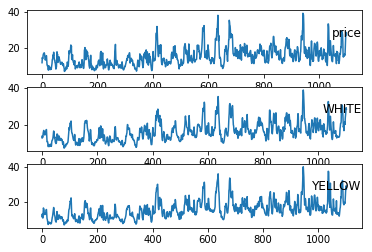

In [4]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('BI-COLOR PRICE weeks.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

# Step 5: LSTM Data Preparation

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('BI-COLOR PRICE weeks.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
##values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.149551   0.177804   0.143801  0.237484
2   0.237484   0.214058   0.188242  0.217458
3   0.217458   0.182164   0.124340  0.220796
4   0.220796   0.201168   0.117929  0.281558
5   0.281558   0.255437   0.226221  0.299101


# Step 6: Split the data into Training Set (first 70% rows) and Validation Set (remaining 30% rows)
### - The first 3 columns (0 to 2) are our features used as input to the model
### - The last column (3) is the output variable

In [6]:
# split into train and test sets
values = reframed.values
train = values[:int(len(values)*0.7), :]
test = values[int(len(values)*0.7):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(769, 1, 3) (769,) (330, 1, 3) (330,)


# Step 7: Create a LSTM network model with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting price.
### The input shape will be 1 time step with 3 features.

In [7]:
# Design network
model = Sequential()
# Check LSTM
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


## Step 6: Check for proper neural connections by compiling the model
### We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

In [0]:
model.compile(loss='mae', optimizer='adam', metrics=['mse']) # mse = mean squared error

## Step 7: Do the Training (Fit the model)
At the end of the run both the training and test loss are plotted.

### The model will be fit for 50 training epochs with a batch size of 72.



Instructions for updating:
Use tf.cast instead.
Train on 770 samples, validate on 331 samples
Epoch 1/50
 - 1s - loss: 0.3521 - mean_squared_error: 0.1394 - val_loss: 0.4076 - val_mean_squared_error: 0.1808
Epoch 2/50
 - 0s - loss: 0.2924 - mean_squared_error: 0.0984 - val_loss: 0.3368 - val_mean_squared_error: 0.1260
Epoch 3/50
 - 0s - loss: 0.2280 - mean_squared_error: 0.0625 - val_loss: 0.2591 - val_mean_squared_error: 0.0781
Epoch 4/50
 - 0s - loss: 0.1564 - mean_squared_error: 0.0327 - val_loss: 0.1714 - val_mean_squared_error: 0.0392
Epoch 5/50
 - 0s - loss: 0.0801 - mean_squared_error: 0.0121 - val_loss: 0.0911 - val_mean_squared_error: 0.0155
Epoch 6/50
 - 0s - loss: 0.0550 - mean_squared_error: 0.0055 - val_loss: 0.0726 - val_mean_squared_error: 0.0107
Epoch 7/50
 - 0s - loss: 0.0608 - mean_squared_error: 0.0058 - val_loss: 0.0731 - val_mean_squared_error: 0.0109
Epoch 8/50
 - 0s - loss: 0.0576 - mean_squared_error: 0.0059 - val_loss: 0.0779 - val_mean_squared_error: 0.0122
Ep

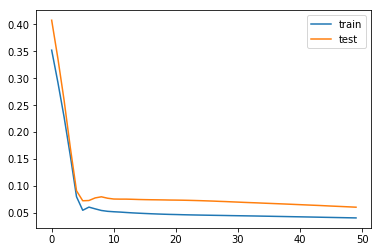

In [12]:
# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### The model will be fit for 1000 training epochs with a batch size of 72.

Train on 770 samples, validate on 331 samples
Epoch 1/1000
 - 0s - loss: 0.0406 - mean_squared_error: 0.0032 - val_loss: 0.0601 - val_mean_squared_error: 0.0078
Epoch 2/1000
 - 0s - loss: 0.0404 - mean_squared_error: 0.0032 - val_loss: 0.0596 - val_mean_squared_error: 0.0077
Epoch 3/1000
 - 0s - loss: 0.0402 - mean_squared_error: 0.0031 - val_loss: 0.0592 - val_mean_squared_error: 0.0076
Epoch 4/1000
 - 0s - loss: 0.0399 - mean_squared_error: 0.0031 - val_loss: 0.0588 - val_mean_squared_error: 0.0075
Epoch 5/1000
 - 0s - loss: 0.0398 - mean_squared_error: 0.0031 - val_loss: 0.0582 - val_mean_squared_error: 0.0074
Epoch 6/1000
 - 0s - loss: 0.0396 - mean_squared_error: 0.0030 - val_loss: 0.0578 - val_mean_squared_error: 0.0073
Epoch 7/1000
 - 0s - loss: 0.0393 - mean_squared_error: 0.0030 - val_loss: 0.0572 - val_mean_squared_error: 0.0072
Epoch 8/1000
 - 0s - loss: 0.0392 - mean_squared_error: 0.0030 - val_loss: 0.0567 - val_mean_squared_error: 0.0071
Epoch 9/1000
 - 0s - loss: 0.0390 

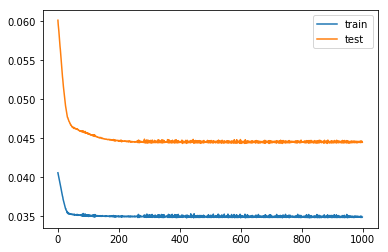

In [13]:
# Fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### The model will be fit for 1000 training epochs with a batch size of 1.

Train on 770 samples, validate on 331 samples
Epoch 1/1000
 - 2s - loss: 0.0439 - mean_squared_error: 0.0037 - val_loss: 0.0693 - val_mean_squared_error: 0.0086
Epoch 2/1000
 - 2s - loss: 0.0419 - mean_squared_error: 0.0033 - val_loss: 0.0653 - val_mean_squared_error: 0.0078
Epoch 3/1000
 - 2s - loss: 0.0397 - mean_squared_error: 0.0031 - val_loss: 0.0601 - val_mean_squared_error: 0.0069
Epoch 4/1000
 - 2s - loss: 0.0394 - mean_squared_error: 0.0030 - val_loss: 0.0542 - val_mean_squared_error: 0.0061
Epoch 5/1000
 - 2s - loss: 0.0388 - mean_squared_error: 0.0029 - val_loss: 0.0578 - val_mean_squared_error: 0.0066
Epoch 6/1000
 - 2s - loss: 0.0387 - mean_squared_error: 0.0029 - val_loss: 0.0585 - val_mean_squared_error: 0.0067
Epoch 7/1000
 - 2s - loss: 0.0387 - mean_squared_error: 0.0029 - val_loss: 0.0557 - val_mean_squared_error: 0.0063
Epoch 8/1000
 - 2s - loss: 0.0387 - mean_squared_error: 0.0029 - val_loss: 0.0565 - val_mean_squared_error: 0.0064
Epoch 9/1000
 - 2s - loss: 0.0389 

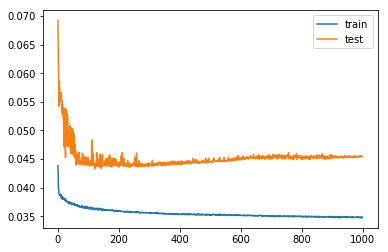

In [14]:
# Fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Overfitting. So change the Epochs to 123, which is when the best loss showed above.

Instructions for updating:
Use tf.cast instead.
Train on 769 samples, validate on 330 samples
Epoch 1/123
 - 7s - loss: 0.0656 - mean_squared_error: 0.0084 - val_loss: 0.0727 - val_mean_squared_error: 0.0100
Epoch 2/123
 - 4s - loss: 0.0512 - mean_squared_error: 0.0053 - val_loss: 0.0624 - val_mean_squared_error: 0.0074
Epoch 3/123
 - 4s - loss: 0.0480 - mean_squared_error: 0.0045 - val_loss: 0.0590 - val_mean_squared_error: 0.0068
Epoch 4/123
 - 4s - loss: 0.0471 - mean_squared_error: 0.0043 - val_loss: 0.0569 - val_mean_squared_error: 0.0063
Epoch 5/123
 - 4s - loss: 0.0465 - mean_squared_error: 0.0043 - val_loss: 0.0596 - val_mean_squared_error: 0.0067
Epoch 6/123
 - 4s - loss: 0.0458 - mean_squared_error: 0.0042 - val_loss: 0.0585 - val_mean_squared_error: 0.0065
Epoch 7/123
 - 4s - loss: 0.0454 - mean_squared_error: 0.0041 - val_loss: 0.0577 - val_mean_squared_error: 0.0063
Epoch 8/123
 - 4s - loss: 0.0455 - mean_squared_error: 0.0041 - val_loss: 0.0621 - val_mean_squared_error: 0

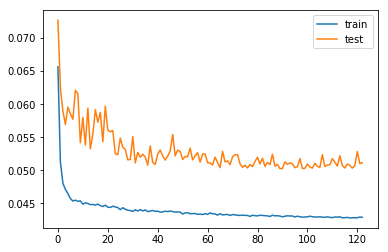

In [9]:
# Fit network
history = model.fit(train_X, train_y, epochs=123, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Step 8: The real test of the model we trained
**Evaluate the model on the Test data, calculate the Root Mean Squared Error (RMSE) **

In [10]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.324


## Calculate R^2 (coefficient of determination) regression score

In [17]:
import math
from keras.models import load_model
model.save('my_model.h5')
model = load_model('my_model.h5')
from sklearn.metrics import r2_score
#trainScore = math.sqrt(r2_score(test_y[0],  yhat[:,0]))
#print('Train Score: %.2f R2' % (trainScore))
testScore = math.sqrt(r2_score(inv_y, inv_yhat))
print('Test Score: %.2f R2' % (testScore))

Test Score: 0.82 R2
